In [1]:
import tarfile

In [2]:
# gz_file_path="/content/drive/MyDrive/ML-POC/trainval.tar.gz"
# with tarfile.open(gz_file_path, 'r') as f:
#   f.extractall("/content/drive/MyDrive/ML-POC/")

In [2]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import Activation, BatchNormalization, MaxPool2D
from keras.layers import UpSampling2D, Input
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
import tensorflow
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint
import cv2

###**ESSENTIAL FUNCTION**

In [3]:
def conv_block(input, num_of_filters):
  #First Set
  conv_op=Conv2D(num_of_filters, 3, padding="same")(input)
  conv_op=BatchNormalization()(conv_op)
  conv_op = Activation('relu')(conv_op)

  #Second Set
  conv_op=Conv2D(num_of_filters, 3, padding="same")(conv_op)
  conv_op=BatchNormalization()(conv_op)
  conv_op = Activation('relu')(conv_op)

  return conv_op

def encoder_block(input, num_of_filters):
  encode = conv_block(input, num_of_filters)
  max_pool = MaxPool2D(pool_size=(2,2))(encode)

  return encode, max_pool

def decoder_block(input, skip_connection, num_of_filters):
  conv_trans = Conv2DTranspose(num_of_filters, (2,2), strides=2, padding="same")(input)
  conv_trans = Concatenate()([conv_trans, skip_connection])
  conv_trans = conv_block(conv_trans, num_of_filters)

  return conv_trans


#create model with specific input and no of classes
def create_model(input_shape, num_classes):

  inputs=Input(input_shape)

  c1,p1=encoder_block(inputs, 64)
  c2,p2=encoder_block(p1, 128)
  c3,p3=encoder_block(p2, 256)
  c4,p4=encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, c4, 512)
  d2 = decoder_block(d1, c3, 256)
  d3 = decoder_block(d2, c2, 128)
  d4 = decoder_block(d3, c1, 64)

  activation=""
  if num_classes==1:
    activation = "sigmoid"
  else:
    activation = "softmax"
  print(activation, num_classes, sep=" ")
  output = Conv2D(num_classes, 1, padding="same", activation=activation)(d4)

  model = Model(inputs=inputs, outputs=output, name="U-net-Model")
  return model

In [4]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())
    

In [8]:
def show_top_images_with_lables(images, lables, plot_random=True):
  columns = 4
  rows = 5
  fig=plt.figure(figsize=(12, 17))
  for i in range(1, columns*rows +1):
    index = None
    if plot_random == True:
      index = randint(0, (len(lables)-1))
    else:
      index = i
    fig.add_subplot(rows, columns, i).set_title(lables[index-1])
    plt.imshow(images[index-1], cmap='gray')
  return plt.show()

In [5]:
input_shape = (256,256,3)
my_unet_model = create_model(input_shape, num_classes=3)
my_unet_model.summary()

softmax 3
Model: "U-net-Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                             

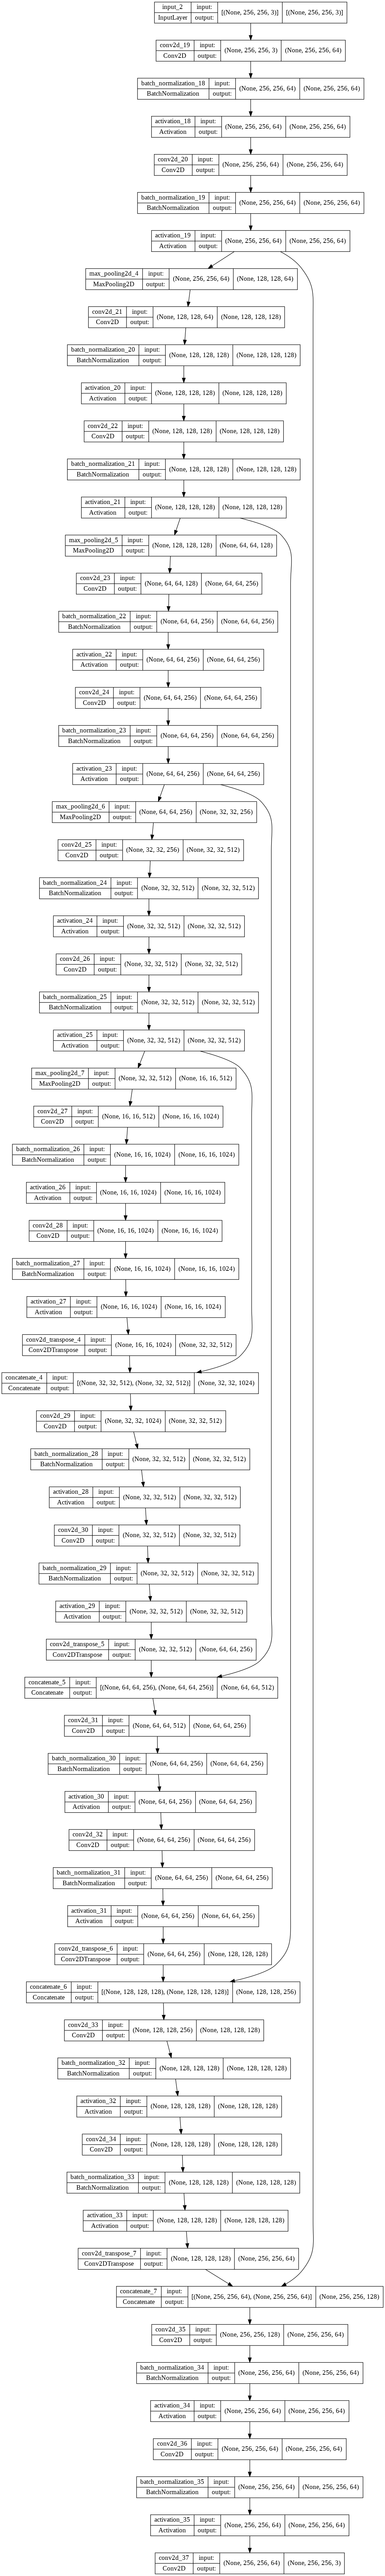

In [96]:
plot_model(my_unet_model, "my_unet_model.png", show_shapes=True, show_layer_names=True)

In [6]:
from glob import glob
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from keras_preprocessing.image import load_img, img_to_array
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import pickle

In [7]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizer_v2.adam import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [9]:
json_path="/content/drive/MyDrive/ML-POC/trainval/annotations/bbox-annotations.json"
images_path="/content/drive/MyDrive/ML-POC/trainval/images/"
images_path

'/content/drive/MyDrive/ML-POC/trainval/images/'

In [36]:
image_height=256
image_width=256

In [10]:
imgs_path=glob("{}*".format(images_path))
imgs_path.sort()
imgs_path[0]

'/content/drive/MyDrive/ML-POC/trainval/images/image_000000001.jpg'

In [11]:
len(imgs_path)

2239

In [12]:
json_file=open(json_path, 'r')
json_data = json.loads(json_file.read())
json_file.close()

In [38]:
def getCoordinates(annotations, image_jdata):
  coordinates=[]
  for annotation in annotations:
    if annotation['image_id'] == image_jdata["id"]:
      x,y,w,h = annotation['bbox']
      x = x/image_jdata['width']
      w = w/image_jdata['width']
      y = y/image_jdata['height']
      h = h/image_jdata['height']
      cc = (annotation["category_id"], [x,y,w,h])
      coordinates.append(cc)
  return (image_jdata["id"], coordinates)

dict_keys(['images', 'annotations', 'categories', 'licenses'])

In [14]:
images = json_data['images']
categories = json_data['categories']
annotations = json_data['annotations']

['file_name', 'width', 'height', 'id', 'license']

In [20]:
len(images), len(annotations), len(categories)

(2239, 16772, 2)

In [25]:
(categories[0]['id'], categories[0]['name']), (categories[1]['id'], categories[1]['name'])

((1, 'person'), (2, 'car'))

In [15]:
images[0]['file_name'], images[0]['id'], images[0]['width'], images[0]['height']

('image_000000001.jpg', 0, 1024, 768)

In [16]:
annotations[0]["category_id"], annotations[0]["image_id"], annotations[0]["bbox"] , annotations[0]["id"] 

(1, 0, [846, 145, 146, 477], 0)

In [39]:
image_data=[]
coordinates_data=[]
image_ids=[]
for i,img_path in tqdm(enumerate(imgs_path)):
  img = load_img(img_path, target_size=(image_height, image_width))
  img = np.array(img)
  coo = getCoordinates(annotations, images[i])
  id, cc = coo
  coordinates_data.append(cc)
  image_data.append(img)
  image_ids.append(id)
image_data = np.array(image_data)
coordinates_data = np.array(coordinates_data)
image_ids=np.array(image_ids)

2239it [12:18,  3.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [48]:
image_data = image_data/255.

In [46]:
coordinates_data[1]

[(1, [0.4765625, 0.4878472222222222, 0.02734375, 0.1232638888888889]),
 (2, [0.025390625, 0.4913194444444444, 0.1416015625, 0.13020833333333334]),
 (2, [0.578125, 0.4982638888888889, 0.1181640625, 0.171875])]

In [45]:
image_ids[0]

0

In [75]:
masks = []
for coordinates in tqdm(coordinates_data):
  mask=np.zeros((image_height, image_width))
  for c in coordinates:
    cat, bbox = c
    x,y,w,h = bbox
    x = int(x * image_width)
    w = int(w * image_width)
    y = int(y * image_height)
    h = int(h * image_height)
    mask[y:h,x:w] = cat
  masks.append(mask)

masks = np.array(masks)

100%|██████████| 2239/2239 [00:00<00:00, 6947.54it/s]


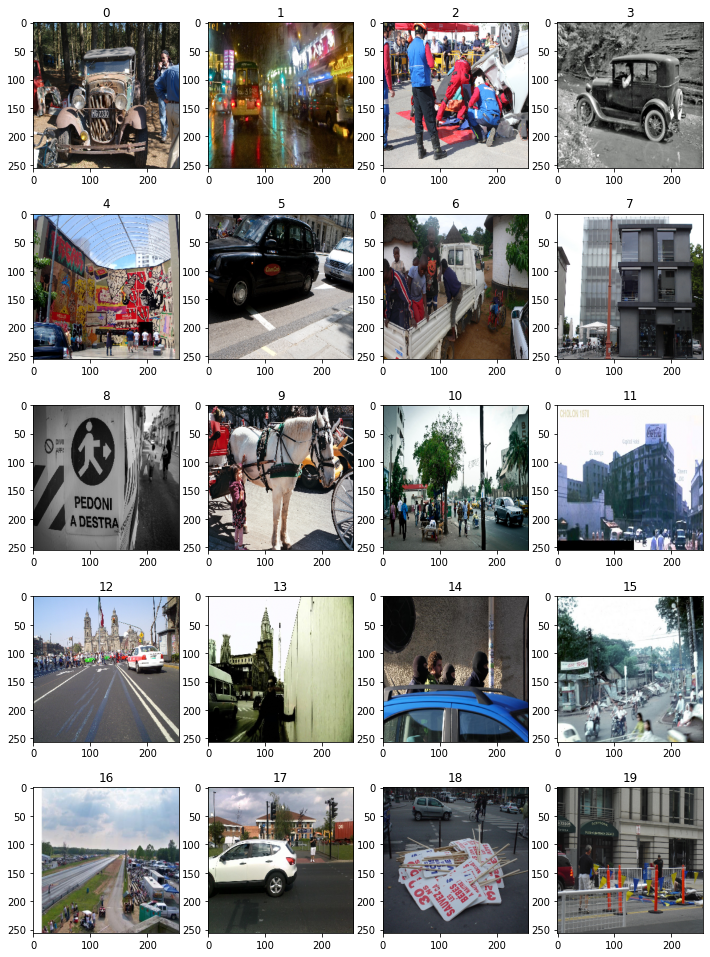

In [72]:
show_top_images_with_lables(image_data, image_ids, False)

In [61]:
masks.shape

(2239, 256, 256)

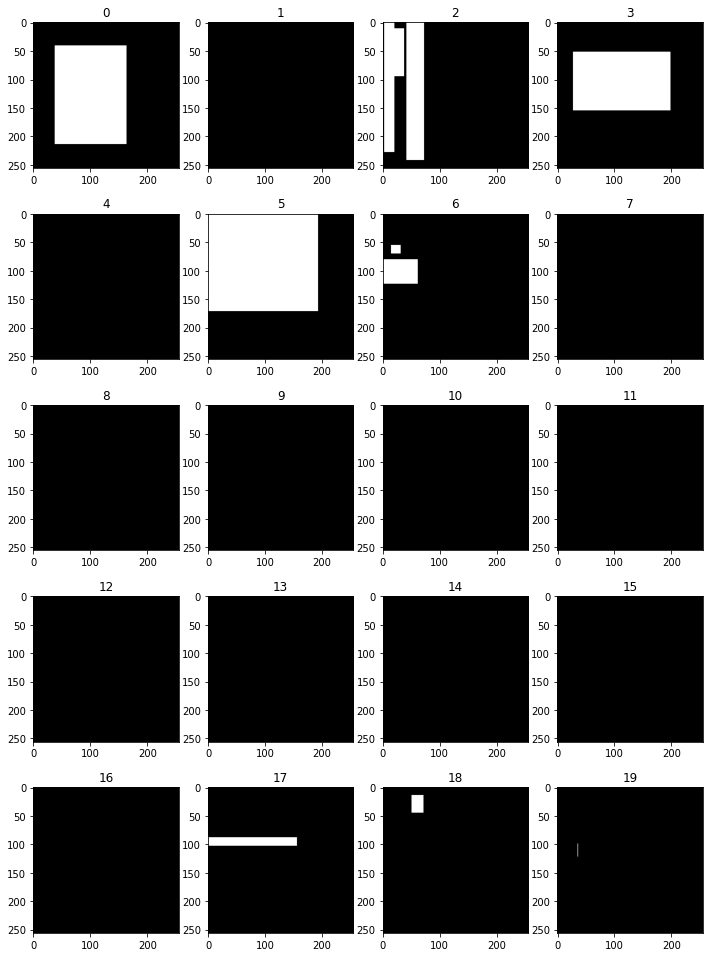

In [76]:
show_top_images_with_lables(masks, image_ids, False)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(image_data, masks, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1567, 256, 256, 3), (672, 256, 256, 3), (1567, 256, 256), (672, 256, 256))

In [80]:
dataset = {
    "image_data": image_data,
    "image_ids": image_ids,
    "masks": masks
}

with open("/content/drive/MyDrive/ML-POC/dataset.pkl", 'ab') as f:
  pickle.dump(dataset,f)

In [97]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
my_unet_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [98]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML-POC/weights/model-weights-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True) # To Save the weight of the best performing model
early_stop = EarlyStopping(monitor="val_loss", patience=5) #Stop Early if the model converges very quickly before it over fits.

In [89]:
train_cat_msk = to_categorical(y_train, num_classes=3)
y_train_cat = train_cat_msk.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 3)

test_cat_msk = to_categorical(y_test, num_classes=3)
y_test_cat = test_cat_msk.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 3)

In [90]:
y_train_cat.shape,y_test_cat.shape

((1567, 256, 256, 3), (672, 256, 256, 3))

In [92]:
no_epochs = 50

In [99]:
with tf.device('/device:GPU:0'):
  history = my_unet_model.fit(X_train, y_train_cat, validation_data = (X_test, y_test_cat), epochs=no_epochs, batch_size=10, verbose=1, callbacks=[checkpoint,early_stop])

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 1.2785 - dice_coefficient: 0.5931
Epoch 1: val_loss improved from inf to 1.11319, saving model to /content/drive/MyDrive/ML-POC/weights/model-weights-1.11.h5
157/157 [==============================] - 67s 346ms/step - loss: 1.2785 - dice_coefficient: 0.5931 - val_loss: 1.1132 - val_dice_coefficient: 0.6150
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.9596 - dice_coefficient: 0.6848
Epoch 2: val_loss improved from 1.11319 to 0.88993, saving model to /content/drive/MyDrive/ML-POC/weights/model-weights-0.89.h5
157/157 [==============================] - 51s 324ms/step - loss: 0.9596 - dice_coefficient: 0.6848 - val_loss: 0.8899 - val_dice_coefficient: 0.7419
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 0.8738 - dice_coefficient: 0.7138
Epoch 3: val_loss did not improve from 0.88993
157/157 [==============================] - 50s 320ms/step - loss: 0.8738 - dice_coefficie

In [8]:
pickle_path = '/content/drive/MyDrive/ML-POC/dataset.pkl'
pkl_file = open(pickle_path, 'rb')
img_ds = pickle.load(pkl_file)
pkl_file.close()

In [9]:
image_data = img_ds["image_data"]
masks = img_ds["masks"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(image_data, masks, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1567, 256, 256, 3), (672, 256, 256, 3), (1567, 256, 256), (672, 256, 256))

In [11]:
train_cat_msk = to_categorical(y_train, num_classes=3)
y_train_cat = train_cat_msk.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 3)

test_cat_msk = to_categorical(y_test, num_classes=3)
y_test_cat = test_cat_msk.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 3)

In [12]:
my_unet_model.load_weights('/content/drive/MyDrive/ML-POC/weights/model-weights-0.61.h5')

In [13]:
pred = my_unet_model.predict(test_cat_msk)
pred.shape

(672, 256, 256, 3)

In [14]:
y_pred = np.argmax(pred, axis=3)
y_pred.shape

(672, 256, 256)

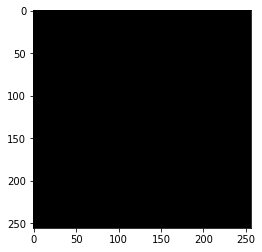

In [15]:
i=120
plt.imshow(y_pred[i], cmap='gray')

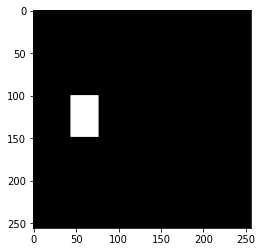

In [17]:
plt.imshow(y_test[i], cmap='gray')

In [38]:
i=125

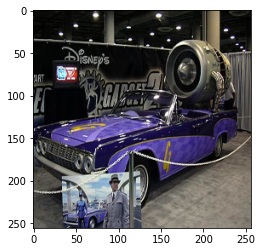

In [39]:
plt.imshow(X_test[i], cmap='gray')

In [40]:
img = X_test[i]
img = np.expand_dims(img, axis=0)
img_pred = my_unet_model.predict(img)
img_pred.shape

(1, 256, 256, 3)

In [41]:
dd = np.argmax(img_pred, axis=3)
#dd.shape

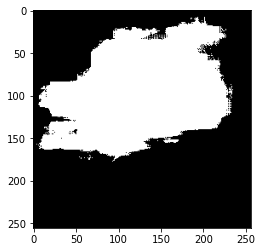

In [42]:
plt.imshow(dd[0], cmap='gray')

In [43]:
new_cp_img = dd[0]
norm_new_cp_img = cv2.normalize(new_cp_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_new_cp_img = norm_new_cp_img.astype(np.uint8)

_, difference = cv2.threshold(norm_new_cp_img, 200, 255, cv2.THRESH_BINARY)
difference = cv2.dilate(difference, None, iterations=2)
contours, hierarchy = cv2.findContours(difference.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

x: 2, y: 6, w: 235 h: 174
[]


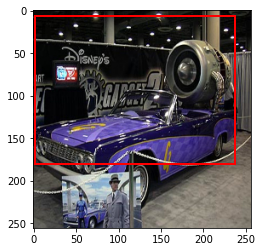

In [45]:
for count in contours:
  if cv2.contourArea(count) < 500:
    continue
  (x, y, w, h) =  cv2.boundingRect(count)
  print(f"x: {x}, y: {y}, w: {(w)} h: {(h)}")
  #face_count = face_count+1
  print(np.unique(norm_new_cp_img[h:y,x:w]))

  fig,ax = plt.subplots(1)
  ax.imshow(X_test[i]) # Display the image
  rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()